In [1]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [2]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import random

np.random.seed(0)

2022-08-26 03:56:14.097407: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/sametaydin/.local/lib/python3.10/site-packages/cv2/../../lib64:
2022-08-26 03:56:14.097470: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
with open('german-traffic-signs/train.p','rb') as f:
    train_data = pickle.load(f)
with open('german-traffic-signs/valid.p','rb') as f:
    val_data = pickle.load(f)
with open('german-traffic-signs/test.p','rb') as f:
    test_data = pickle.load(f)

print(type(train_data)) #dict

X_train , y_train = train_data['features']  , train_data['labels'] 
X_val , y_val = val_data['features']  , val_data['labels'] 
X_test , y_test = test_data['features']  , test_data['labels'] 


<class 'dict'>


In [4]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)


(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [5]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels"
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels"
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels"

assert(X_train.shape[1:] == (32,32,3)),"The dimensions ofthe images are not 32x32x3"
assert(X_val.shape[1:] == (32,32,3)),"The dimensions ofthe images are not 32x32x3"
assert(X_test.shape[1:] == (32,32,3)),"The dimensions ofthe images are not 32x32x3"

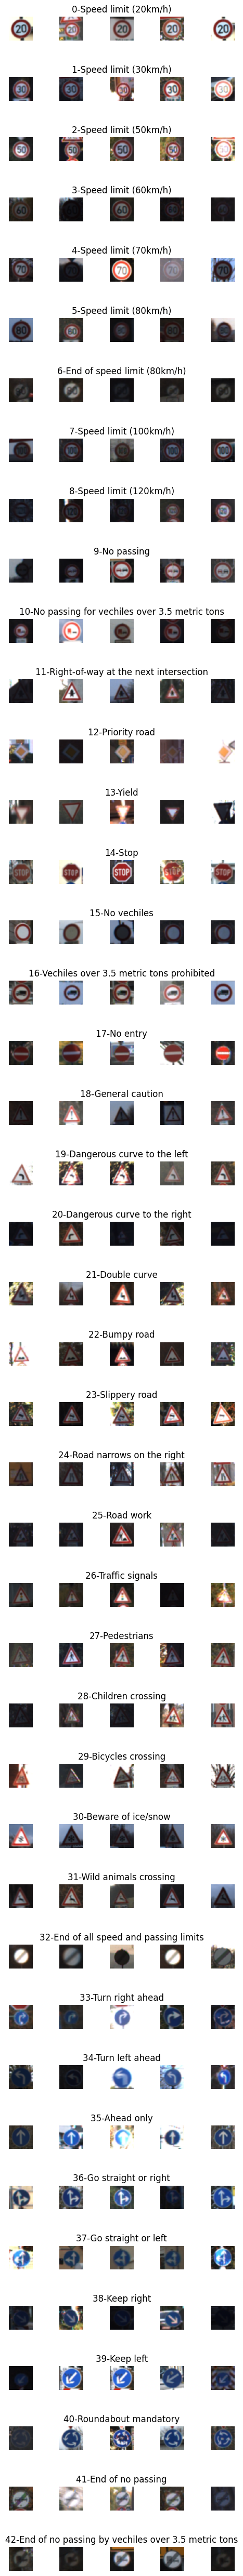

In [6]:
data = pd.read_csv("german-traffic-signs/signnames.csv")

num_of_samples = []
    
cols = 5
num_classes = 43
    
fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(5, 50))
fig.tight_layout()

for i in range(cols):
    for j,row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected - 1)), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + "-" + row['SignName'])
            num_of_samples.append(len(x_selected))
            
    #(index,series)

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0, 0.5, 'Number of images')

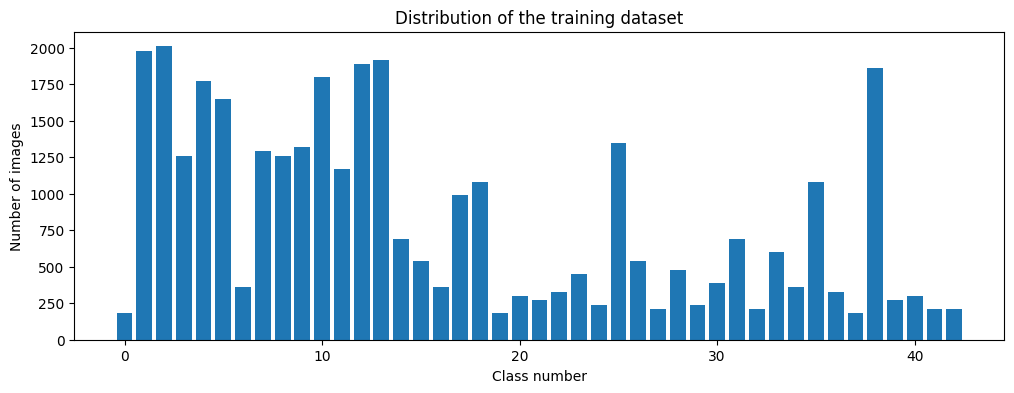

In [7]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")

(32, 32, 3)
36


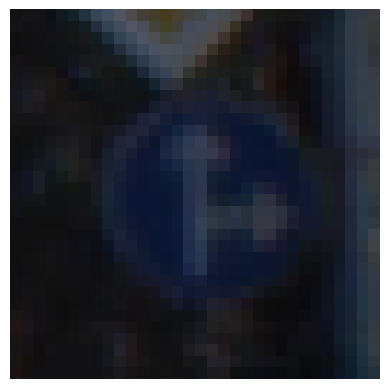

In [8]:
plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])

In [9]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img



(-0.5, 31.5, 31.5, -0.5)

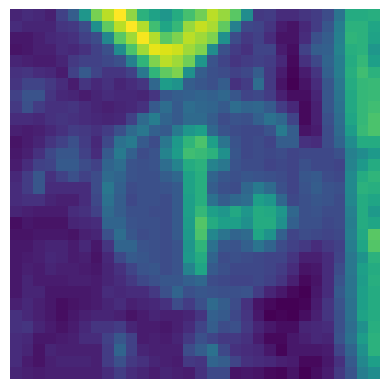

In [10]:
img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis("off")

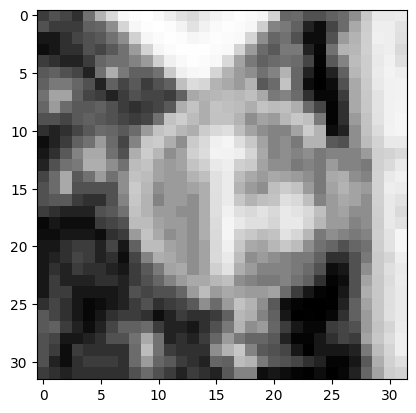

In [11]:

def equalize(img):
    img = cv2.equalizeHist(img)
    return img

img = equalize(img)
plt.imshow(img, cmap='gray')

In [12]:
def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img


In [13]:
X_train = np.array(list(map(preprocessing,X_train)))
X_val = np.array(list(map(preprocessing,X_val)))
X_test = np.array(list(map(preprocessing,X_test)))



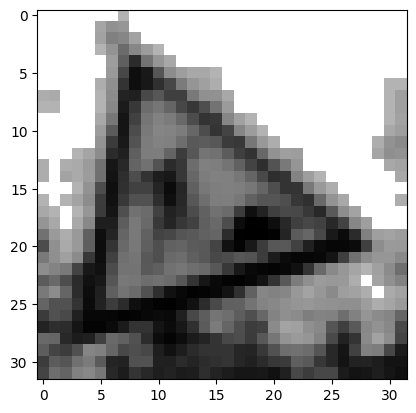

In [14]:
plt.imshow(X_train[random.randint(0,len(X_train) - 1)], cmap="gray")

In [15]:
X_train = X_train.reshape(34799,32,32,1)
X_test = X_test.reshape(12630,32,32,1)
X_val = X_val.reshape(4410,32,32,1)

In [39]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range= 0.1,
                   height_shift_range= 0.1,
                   zoom_range =0.2,
                   shear_range=0.1,
                   rotation_range=10)

datagen.fit(X_train)



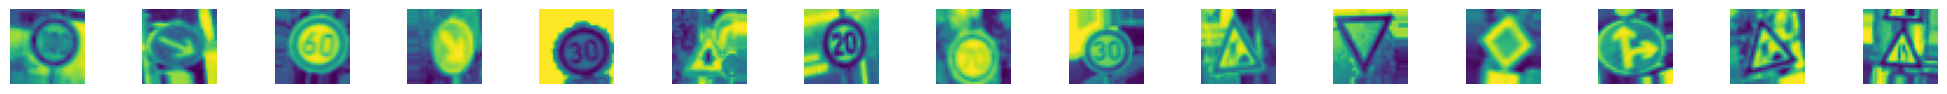

In [42]:
batches = datagen.flow(X_train, y_train,batch_size=20)
X_batch, y_batch = next(batches)

fig , axs = plt.subplots(1,15,figsize= (20,5))
fig.tight_layout()

for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32,32))
    axs[i].axis('off')

In [16]:
y_train = to_categorical(y_train,43)
y_test = to_categorical(y_test,43)
y_val = to_categorical(y_val,43)


In [17]:

def leNet_model():
    model = Sequential()
    model.add(Conv2D(60,(5,5), input_shape= (32,32,1),activation = 'relu'))  # 28x28 x 30
    model.add(MaxPooling2D(pool_size =(2,2)))
    
    model.add(Conv2D(30,(3,3),activation = 'relu'))  # 14x14 30
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Flatten())
    model.add(Dense(500,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(43,activation='softmax'))
    
    model.compile(Adam(lr=0.001),loss = 'categorical_crossentropy',metrics = ['accuracy'])
    return model

In [18]:
model = leNet_model()

2022-08-26 03:56:35.024885: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-26 03:56:35.025616: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/sametaydin/.local/lib/python3.10/site-packages/cv2/../../lib64:
2022-08-26 03:56:35.025792: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/sametaydin/.local/lib/python3.10/site-packages/cv2/../../lib64:
2022-08-26 03:56:35.025889: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dler

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 60)        1560      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 60)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 30)        16230     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 30)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1080)              0         
                                                                 
 dense (Dense)               (None, 500)               5

In [46]:
## history = model.fit(X_train, y_train, epochs = 10, validation_data=(X_val,y_val), batch_size = 400, verbose = 1, shuffle =1)
history = model.fit_generator(datagen.flow(X_train,y_train,batch_size=50),steps_per_epoch=2000,epochs=10,validation_data = (X_val,y_val),shuffle=1)
#veri tükendi hatası alıyorum 

Epoch 1/10
   1/2000 [..............................] - ETA: 2:47 - loss: 1.0325 - accuracy: 0.7000

/tmp/ipykernel_19451/2694059671.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train,y_train,batch_size=50),steps_per_epoch=2000,epochs=10,validation_data = (X_val,y_val),shuffle=1)


2000/2000 [==============================] - 52s 26ms/step - loss: 0.6289 - accuracy: 0.8011 - val_loss: 0.1825 - val_accuracy: 0.9456


Text(0.5, 0, 'epoch')

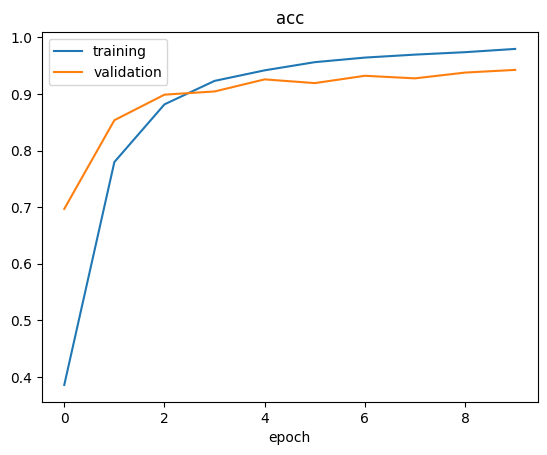

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('acc')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

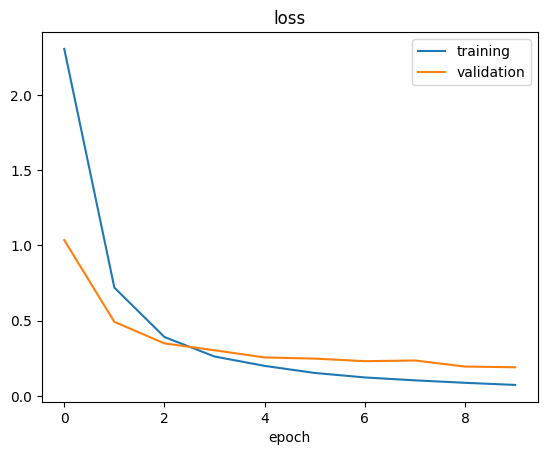

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('loss')
plt.xlabel('epoch')

In [23]:
score = model.evaluate(X_test,y_test,verbose = 0)
print(score) #test score and test accuracy


[0.3190156817436218, 0.9196357727050781]


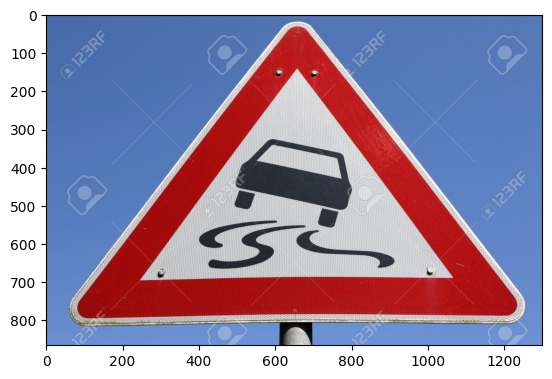

In [33]:
import requests
from PIL import Image
# url = 'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'
#url = "https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg"
url = "https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg"
#url = "https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg"
#url = "https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg"
#url = "https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg"

r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


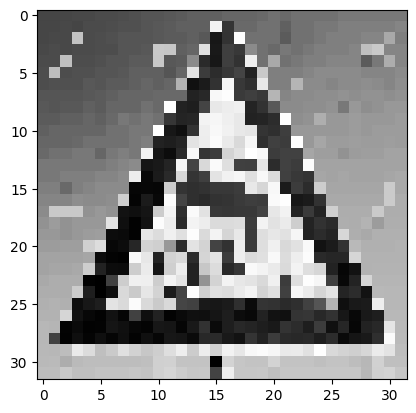

In [34]:
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [35]:
img = img.reshape(1,32,32,1)

In [36]:

predict_x=model.predict(img) 
classes_x=np.argmax(predict_x,axis=1)
str(classes_x)

1/1 [==============================] - 0s 16ms/step


'[23]'